In [ ]:
! pip install conllu
! pip install graphviz
! pip install ufal.udpipe
! wget -q -O russian-ud-2.0-170801.udpipe https://github.com/jwijffels/udpipe.models.ud.2.0/blob/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe?raw=true
! wget -q https://github.com/ufal/udpipe/releases/download/v1.2.0/udpipe-1.2.0-bin.zip; unzip -qq udpipe-1.2.0-bin.zip; mv udpipe-1.2.0-bin/bin-linux64/udpipe ./udpipe;

replace udpipe-1.2.0-bin/bin-linux32/csharp/Ufal/UDPipe/Trainer.cs? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Depencency parsing
(парсинг зависимостей)

## Что это?

* наша цель -- представить предложение естественного языка в виде дерева
* слова предложения -- вершины; *зависимости (dependencies)* между ними -- рёбра
* зависимости могут быть разными: например, субъект глагола, объект глагола, прилагательное-модификатор, и так далее

## Формат

Существует несколько форматов записи деревьев зависимостей, но самый популярный и общеиспользуемый -- [CoNLL-U](http://universaldependencies.org/format.html).<br/>
Как это выглядит (пример из [русского Universal Dependency трибанка](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)):

In [2]:
my_example = """
# sent_id = 2003Armeniya.xml_138
# text = Перспективы развития сферы высоких технологий.
1	Перспективы	перспектива	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur	0	ROOT	0:root	_
2	развития	развитие	NOUN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	1	nmod	1:nmod	_
3	сферы	сфера	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	2:nmod	_
4	высоких	высокий	ADJ	_	Case=Gen|Degree=Pos|Number=Plur	5	amod	5:amod	_
5	технологий	технология	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur	3	nmod	3:nmod	SpaceAfter=No
6	.	.	PUNCT	_	_	1	punct	1:punct	_
"""

Комментарии + таблица c 9 колонками (разделители табы):
* ID: начинается с 1, 0 зарезервирован для root.
* FORM: токен.
* LEMMA: начальная форма.
* UPOS: универсальная часть речи.
* XPOS: лингво-специфичная часть речи.
* FEATS: морфологическая информация: падеж, род, число etc.
* HEAD: id ролителя.
* DEPREL: тип зависимости, то есть отношение к токену-родителю.
* DEPS: альтернативный подграф (не будем углубляться :))
* MISC: всё остальное.

Отсутствующие данные представляются с помощью `_`. Больше подробностей про формат -- в [официальной документаци](http://universaldependencies.org/format.html).<br>
User-friendly визуализация: 

![armenia dependency](https://drive.google.com/uc?id=1aIpgdpZyqryfSMtUpp15Dq2t7KNTXuzH)

Отрытый инструмент для визуализации, ручной разметки и конвертации в другие форматы: UD Annotatrix. [Online-интерфейс](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), [репозиторий](https://github.com/jonorthwash/ud-annotatrix).

Трибанк -- много таких предложений. Обычно они разделяются двумя переносами строки.
### Как считывать данные в питоне

Используем библиотеку [conllu](https://github.com/EmilStenstrom/conllu).

In [1]:
from conllu import parse

In [0]:
help(parse)

Help on function parse in module conllu:

parse(data, fields=None, field_parsers=None, metadata_parsers=None)



In [3]:
sentences = parse(my_example)
sentence = sentences[0]
sentence[0]

NameError: name 'parse' is not defined

In [4]:
sentence[-1]

NameError: name 'sentence' is not defined

## Визуализация

В nltk есть [DependencyGraph](https://www.nltk.org/api/nltk.parse.html?highlight=dependencygraph#nltk.parse.dependencygraph.DependencyGraph), который умеет рисовать деревья (и ещё многое другое). Для того, чтобы визуализация работала корректно, ему нужна зависимость: graphviz. (Если что-то не работает, возможно, стоит поставить 
pygraphviz)

```
sudo apt-get install graphviz
pip install graphviz
```

In [5]:
from nltk import DependencyGraph

В отличие от `conllu`, `DependencyGraph` не справляется с комментариями, поэтому придётся их убрать. Кроме того ему обязательно нужен `deprel` *ROOT* в верхнем регистре, иначе он не находит корень.

In [6]:
def parse_to_graph(dependency: str) -> DependencyGraph:
  lines = dependency.split('\n')
  # nonempty, ignores comments, upcases root deprel.
  lines = [line.replace('\troot\t', '\tROOT\t') for line in lines if not line.startswith('#') and line]
  # Не совсем верно, в английском варианте может заменить лемму root на ROOT, а не вид связи
  # но в рамках данного ноутбука этот недостаток опускается, так как работа идет
  # с русским языком.
  return DependencyGraph(tree_str='\n'.join(lines))
  

In [7]:
graph = parse_to_graph(my_example)
graph

Exception: Cannot find the dot binary from Graphviz package

<DependencyGraph with 7 nodes>

In [8]:
# graph.nodes - словарь, но ключи в нем позиции, 
# так что итерироваться можно с помощью
# for i in range(len(graph.nodes)):
for position, data in graph.nodes.items():
  print(f"Position = {position}\nnode data = {data}")
print(f'\n\nMore readable\n\n')
graph.nodes

Position = 0
node data = {'address': 0, 'word': None, 'lemma': None, 'ctag': 'TOP', 'tag': 'TOP', 'feats': None, 'head': None, 'deps': defaultdict(<class 'list'>, {'ROOT': [1]}), 'rel': None}
Position = 1
node data = {'address': 1, 'word': 'Перспективы', 'lemma': 'перспектива', 'ctag': 'NOUN', 'tag': '_', 'feats': 'Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur', 'head': 0, 'deps': defaultdict(<class 'list'>, {'nmod': [2], 'punct': [6]}), 'rel': 'ROOT'}
Position = 2
node data = {'address': 2, 'word': 'развития', 'lemma': 'развитие', 'ctag': 'NOUN', 'tag': '_', 'feats': 'Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing', 'head': 1, 'deps': defaultdict(<class 'list'>, {'nmod': [3]}), 'rel': 'nmod'}
Position = 3
node data = {'address': 3, 'word': 'сферы', 'lemma': 'сфера', 'ctag': 'NOUN', 'tag': '_', 'feats': 'Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing', 'head': 2, 'deps': defaultdict(<class 'list'>, {'nmod': [5]}), 'rel': 'nmod'}
Position = 4
node data = {'address': 4, 'word': 'высоких', 'l

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'ROOT': [1]}),
              'rel': None},
             1: {'address': 1,
              'word': 'Перспективы',
              'lemma': 'перспектива',
              'ctag': 'NOUN',
              'tag': '_',
              'feats': 'Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur',
              'head': 0,
              'deps': defaultdict(list, {'nmod': [2], 'punct': [6]}),
              'rel': 'ROOT'},
             2: {'address': 2,
              'word': 'развития',
              'lemma': 'развитие',
              'ctag': 'NOUN',
              'tag': '_',
              'feats': 'Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing',
              'head': 1,
       

In [9]:
# pretty_print на случай, если отключили graphviz за неуплату.
tree = graph.tree()
print(tree.pretty_print())

    Перспективы           
  _______|__________       
 |               развития 
 |                  |      
 |                сферы   
 |                  |      
 |              технологий
 |                  |      
 .               высоких  

None


## UDPipe

Есть разные инструменты для парсинга зависимостей. Сегодня мы будем рабтать с [UDPipe](http://ufal.mff.cuni.cz/udpipe). UDPipe умеет парсить текст с помощью готовых моделей (которые можно скачать [здесь](https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)) и обучать модели на своих трибанках.

Собственно, в UDPipe есть три вида моделей:
* токенизатор (разделить предложение на токены, сделать заготовку для CoNLL-U)
* тэггер (разметить части речи)
* сам парсер (проставить каждому токену `head` и `deprel`)

Мы сегодня не будем обучать новых моделей (это слишком долго), а используем готовую модель для русского.

### The Python binding

У udpipe есть питоновская обвязка. Она довольно [плохо задокументирована](https://pypi.org/project/ufal.udpipe/), но зато можно использовать прямо в питоне :)

In [10]:
from ufal.udpipe import Model, Pipeline

In [11]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model
assert model is not None, "Model failed to load"

AssertionError: Model failed to load

In [ ]:
# Pipeline(const Model* m, const string& input, const string& tagger, const string& parser, const string& output);
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Если бы мне платили каждый раз. Каждый раз, когда я думаю о тебе."
parsed = pipeline.process(example)
print(parsed)

Как видим, UDPipe и токенизировал, и лематизировал текст, сделал POS-tagging и, собственно, синтаксический парсинг.

### Command line interface

Но с обвязкой бывают проблемы, и вообще довольно удобно пользоваться прекомпилированной утилитой `udpipe` из шелла. Она скачивается [здесь](https://github.com/ufal/udpipe/releases/tag/v1.2.0): (надеюсь, вы уже скачали всё заранее) (Если вы используете ноутбук из колаба, все уже скачано и распаковано. В противном случае стоит скачать архив и найти нужный бинарь для своей ОС). <br>Внутри бинарники для всех популярных ОС, выбираем свою.

Синтаксис:

In [0]:
! ./udpipe

Usage: ./udpipe [running_opts] model_file [input_files]
       ./udpipe --train [training_opts] model_file [input_files]
       ./udpipe --detokenize [detokenize_opts] raw_text_file [input_files]
Running opts: --accuracy (measure accuracy only)
              --input=[conllu|generic_tokenizer|horizontal|vertical]
              --immediate (process sentences immediately during loading)
              --outfile=output file template
              --output=[conllu|epe|matxin|horizontal|plaintext|vertical]
              --tokenize (perform tokenization)
              --tokenizer=tokenizer options, implies --tokenize
              --tag (perform tagging)
              --tagger=tagger options, implies --tag
              --parse (perform parsing)
              --parser=parser options, implies --parse
Training opts: --method=[morphodita_parsito] which method to use
               --heldout=heldout data file name
               --tokenizer=tokenizer options
               --tagger=tagger options


Нас сегодня будет интересовать только парсинг, так что типичная команда будет выглядеть так:

In [0]:
with open('example.txt', 'w') as f:
    f.write(example)

! cat example.txt
! ./udpipe --tokenize --tag --parse russian-ud-2.0-170801.udpipe example.txt > parsed_example.conllu
! echo
! echo ---------------------- Parsing finished ----------------------
! echo
! cat parsed_example.conllu

Если бы мне платили каждый раз. Каждый раз, когда я думаю о тебе.Loading UDPipe model: done.

---------------------- Parsing finished ----------------------

# newdoc id = example.txt
# newpar
# sent_id = 1
# text = Если бы мне платили каждый раз.
1	Если	ЕСЛИ	SCONJ	IN	_	4	mark	_	_
2	бы	БЫ	PART	RP	_	4	discourse	_	_
3	мне	Я	PRON	PRP	Case=Dat|Number=Sing|Person=1	4	iobj	_	_
4	платили	ПЛАТИТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin	0	root	_	_
5	каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	amod	_	_
6	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	4	advmod	_	SpaceAfter=No
7	.	.	PUNCT	.	_	4	punct	_	_

# sent_id = 2
# text = Каждый раз, когда я думаю о тебе.
1	Каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	amod	_	_
2	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	advmod	_	SpaceAfter=No
3	,	,	PUNCT	,	_	6	punct	_	_
4	когда	КОГДА	ADV	WRB	_	6	advmod	_	_
5	я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=

(Ну а потом снова считываем проанализированные предложения питоном).

Вот два способа работать с UDPipe. Choose your fighter! 

## Главред

Главред -- [сервис](https://glvrd.ru/) для корекции стиля текста. Кроме интерфейса, у него есть [API](https://glvrd.ru/api/)!<br>
На этом семинаре мы имплементируем несколько функций, делающих нечто похожее, на основе синтаксиса.

Возьмём простой пример: предложение, перегруженное однородными членами.

In [0]:
conj = 'Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.'
print(pipeline.process(conj))

# newdoc
# newpar
# sent_id = 1
# text = Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	пришла	приИДТИ	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	включила	включила	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
5	компьютер	компьютер	NOUN	NN	Animacy=Anim|Case=Gen|Gender=Fem|Number=Plur	4	obj	_	SpaceAfter=No
6	,	,	PUNCT	,	_	7	punct	_	_
7	открыла	открЫТЬ	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	4	conj	_	_
8	почту	почТОТ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	7	obj	_	SpaceAfter=No
9	,	,	PUNCT	,	_	10	punct	_	_
10	прочитала	прочитала	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
11	письмо	ПИСЬМО	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	10	obj	_	SpaceAfter=No
12	,	,	PUNCT	,	_	13	p

В таком случае очень много частей предложения, соединённых связью `conj` -- ей обозначаются однородные члены предложения. В таком случае можно просто посчитать количество таких связей:

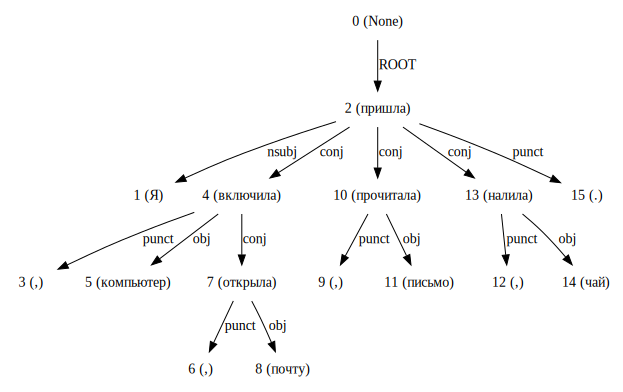

In [0]:
conllu = pipeline.process(conj)
graph = parse_to_graph(conllu)
graph

In [0]:
print(conllu)

# newdoc
# newpar
# sent_id = 1
# text = Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	пришла	приИДТИ	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	включила	включила	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
5	компьютер	компьютер	NOUN	NN	Animacy=Anim|Case=Gen|Gender=Fem|Number=Plur	4	obj	_	SpaceAfter=No
6	,	,	PUNCT	,	_	7	punct	_	_
7	открыла	открЫТЬ	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	4	conj	_	_
8	почту	почТОТ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	7	obj	_	SpaceAfter=No
9	,	,	PUNCT	,	_	10	punct	_	_
10	прочитала	прочитала	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
11	письмо	ПИСЬМО	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	10	obj	_	SpaceAfter=No
12	,	,	PUNCT	,	_	13	p

In [0]:
def count_conj(sentence: str) -> int:
    # ваш код здесь
    conj_num = 0
    conllu = pipeline.process(conj)
    graph = parse_to_graph(conllu)
    for i, node in graph.nodes.items():
      for dep_type, ids in node['deps'].items():
        pass
assert count_conj(conj) == 5, "Неправильное число однородных членов. Провертье, \
считаете ли вы первый член в цепочке."

AssertionError: ignored

Ещё одна проблема, на которую обращают внимание в Главреде -- [парцелляция](http://maximilyahov.ru/blog/all/parcel/). Часто она делает предложения менее читаемыми.

В неумелых руках парцелляция так же вредна, как и многоточие в конце
предложения...

По словам Главреда,
> Признак парцелляции — предложение синтаксически неполное и само по себе не имеет смысла.

Например, в предложении нет субъекта, или вообще что-то странное:

# newdoc
# newpar
# sent_id = 1
# text = А броско, шикарно и выделял бы вас из толпы.
1	А	А	CCONJ	CC	_	2	cc:preconj	_	_
2	броско	броско	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	шикарно	шикаРНО	ADV	RB	_	2	conj	_	_
5	и	И	CCONJ	CC	_	6	cc	_	_
6	выделял	выделял	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
7	бы	БЫ	PART	RP	_	8	discourse	_	_
8	вас	ВЫ	PRON	PRP	Case=Acc|Number=Plur|Person=2	6	obj	_	_
9	из	ИЗ	ADP	IN	_	10	case	_	_
10	толпы	толпы	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	6	obl	_	SpaceAfter=No
11	.	.	PUNCT	.	_	2	punct	_	SpacesAfter=\n




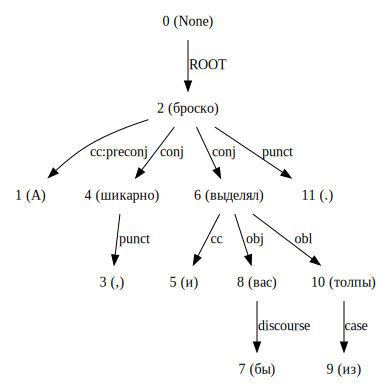

In [0]:
ex = 'А броско, шикарно и выделял бы вас из толпы.'
print(pipeline.process(ex))
parse_to_graph(pipeline.process(ex))

Напишите функцию, которая помогает обнаруживать парцелляцию, опираясь на то, что предложение неполное:

In [0]:
def get_parc(sentence: str) -> bool:
  conllu = pipeline.process(sentence)
  graph = parse_to_graph(conllu)
  for i, node in graph.nodes.items():
    if "subj" in node['deps'].keys():
      return False
  return True

assert get_parc(ex) == True, ""

А теперь давайте усложним критерий на однородные члены: проверим, не состоит ли предложение из большого числа однородных предложений. Для этого проверим, являются ли однородные члены глаголами.

Придумайте метрику для оценки качества предложений на основе написаных функций. Напишите функцию-оцениватель. Пусть она принимает на вход предложение, а возвращает оценку от 1 до 10.

In [0]:
def get_score(sentence):
    # your code here
    return score

Если осталось время, придумайте и напишите свою функцию, которая помогала бы оценивать качество текста. Добавьте её в метрику.

## SVO-triples

С помощью синтекстического парсинга можно извлекать из предложений тройки субъект-объект-глагол, которые можно использовать для извлечения информации из текста.  

In [0]:
sent = """1	Собянин	_	NOUN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|fPOS=NOUN++	2	nsubj	_	_
2	открыл	_	VERB	_	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act|fPOS=VERB++	0	ROOT	_	_
3	новый	_	ADJ	_	Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing|fPOS=ADJ++	4	amod	_	_
4	парк	_	NOUN	_	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing|fPOS=NOUN++	2	dobj	_	_
5	и	_	CONJ	_	fPOS=CONJ++	4	cc	_	_
6	детскую	_	ADJ	_	Case=Acc|Degree=Pos|Gender=Fem|Number=Sing|fPOS=ADJ++	7	amod	_	_
7	площадку	_	NOUN	_	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing|fPOS=NOUN++	4	conj	_	_
8	.	_	PUNCT	.	fPOS=PUNCT++.	2	punct	_	_"""

Тройки слово-слово-связь:

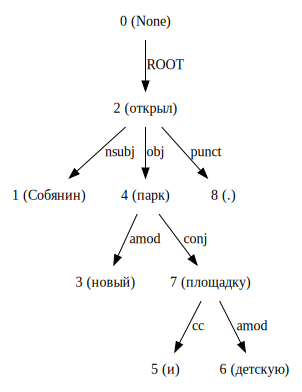

In [0]:
parse_to_graph(pipeline.process('Собянин открыл новый парк и детскую площадку.'))

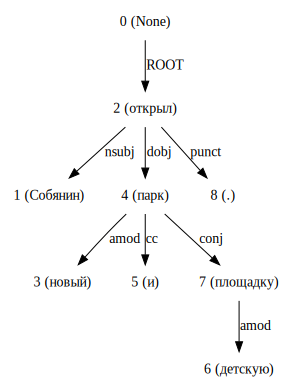

In [0]:
graph = DependencyGraph(tree_str=sent)
graph

In [0]:
list(graph.triples())

[(('открыл', 'VERB'), 'nsubj', ('Собянин', 'NOUN')),
 (('открыл', 'VERB'), 'dobj', ('парк', 'NOUN')),
 (('парк', 'NOUN'), 'amod', ('новый', 'ADJ')),
 (('парк', 'NOUN'), 'cc', ('и', 'CONJ')),
 (('парк', 'NOUN'), 'conj', ('площадку', 'NOUN')),
 (('площадку', 'NOUN'), 'amod', ('детскую', 'ADJ')),
 (('открыл', 'VERB'), 'punct', ('.', 'PUNCT'))]

Тройки субьект-объект-глагол:

In [0]:
def get_sov(sent: str):
    graph = parse_to_graph(sent)
    sov = {}
    for triple in graph.triples():
        if triple:
            if triple[0][1] == 'VERB':
                sov[triple[0][0]] = {'subj':'','obj':''}
    for triple in graph.triples():
        if triple:
            if triple[1] == 'nsubj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['subj']  = triple[2][0]
            if triple[1] in ['dobj', 'obj']:
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['obj'] = triple[2][0]
    return sov

sov = get_sov(sent)
print(sov)

{'открыл': {'subj': 'Собянин', 'obj': 'парк'}}


Измените код выше так, чтобы учитывались:
    1. Однородные члены предложения 
        * (парк, площадка), (Германия, Щвейцария)
    2. Сложные сказуемые 
        * (начнет продавать), (запретил провозить)
    3. Непрямые объекты
        * (едет, Польшу), (спел, скандале)